# Exploring Iterative Solve Results

This notebook explores the results of iterative training of a random forest classifier on migration edges to improve the model's costs and help it select the correct edges more frequently.

We investigate the effect on the metrics with increasing sample size provided to the classifier, as well as the change in costs with more training, and the distribution of edges being sampled at each iteration.

In [96]:
import os
import pandas as pd

initial_root = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint/'
ds_summary_path = os.path.join(initial_root, 'summary.csv')
ds_info = pd.read_csv(ds_summary_path)[['ds_name']]

iterative_root = '/home/ddon0001/PhD/experiments/iterative/'

skip_info = pd.read_csv(os.path.join(initial_root, 'skip_merges.csv'))
ds_info = ds_info.merge(skip_info, left_on='ds_name', right_on='ds_name', how='left')[['ds_name', 'total_skips']]


In [97]:
# gathering info about each iteration for each dataset
# all cumulative
import json
import networkx as nx
import numpy as np
from experiment_schema import OUT_FILE


df_cols = [
    'ds_name',
    'iteration',
    # total number of edges in solution
    'total_sol_edges',
    # 'expected' wrong number of edges (fn nodes + num skip edges)
    'expected_wrong_edges',
    # 'expected' wrong edges as prop of all initial edge errors
    'expected_wrong_prop',
    # number of edges "presented to the user"
    'n_sol_edges_sampled',
    # proportion of all edges in solution "presented to the user"
    'prop_sol_edges_sampled',
    # number of all edges in model whose value has been fixed by user OR by deduction
    'n_all_edges_sampled',
    # proportion of all edges in model whose value has been fixed by user OR by deduction
    'prop_all_edges_sampled',
    # number of edges corrected (i.e. flow value changed) only through user information
    'n_manually_corrected_edges',
    # proportion of all edge errors corrected only through user information
    'prop_manually_corrected_edges',
    # number of FP edges remaining
    'n_fp_edges',
    # proportion of original FP edges remaining
    'prop_fp_edges',
    # number of FN edges remaining
    'n_fn_edges',
    # proportion of original FN edges remaining
    'prop_fn_edges',
    # number of WS edges remaining
    'n_ws_edges',
    # proportion of original WS edges remaining
    'prop_ws_edges',
    # number of edge errors in total remaining
    'total_edge_errors',
    # proportion of original edge errors remaining
    'prop_edge_errors',
    # AOGM
    'AOGM'
]
data = {col: [] for col in df_cols}


for i, row in ds_info.iterrows():
    ds_name = row['ds_name']
    ds_out_root = os.path.join(iterative_root, ds_name)
    ds_init_root = os.path.join(initial_root, ds_name)
    if not os.path.exists(ds_out_root) or ds_name in ['Fluo-C3DH-H157_02', 'Fluo-C3DH-A549_01', 'Fluo-C3DH-A549_02', 'PhC-C2DL-PSC_01']:
        print("Solution not present ", ds_name)
        continue

    with open(os.path.join(ds_out_root, 'sampling_strategy.txt'), 'r') as f:
        sampling_strat = [int(line) for line in f]
    solution_graph = nx.read_graphml(os.path.join(ds_init_root, OUT_FILE.MATCHED_SOL.value), node_type=int)
    sol_cum_sampled = np.cumsum(sampling_strat)

    data['ds_name'].append(ds_name)
    data['total_sol_edges'].append(solution_graph.number_of_edges())
    data['iteration'].append(0)
    data['n_sol_edges_sampled'].append(0)
    data['prop_sol_edges_sampled'].append(0)
    data['n_all_edges_sampled'].append(0)
    data['prop_all_edges_sampled'].append(0)
    data['n_manually_corrected_edges'].append(0)
    data['prop_manually_corrected_edges'].append(0)

    with open(os.path.join(ds_init_root, OUT_FILE.METRICS.value), 'r') as f:
        metrics = json.load(f)
    data['n_fp_edges'].append(metrics['fp_edges'])
    data['prop_fp_edges'].append(1)
    data['n_fn_edges'].append(metrics['fn_edges'])
    data['prop_fn_edges'].append(1)
    data['n_ws_edges'].append(metrics['ws_edges'])
    data['prop_ws_edges'].append(1)

    all_edges = pd.read_csv(os.path.join(ds_init_root, OUT_FILE.ALL_EDGES.value))
    init_n_all_edges = len(all_edges)
    init_n_sol_edges = solution_graph.number_of_edges()
    init_n_fp_edges = metrics['fp_edges']
    init_n_fn_edges = metrics['fn_edges']
    init_n_ws_edges = metrics['ws_edges']
    
    total_init = (init_n_fp_edges + init_n_fn_edges + init_n_ws_edges)
    expected_wrong_edges = metrics['fn_nodes'] + row['total_skips']
    expected_wrong_prop = expected_wrong_edges / total_init if total_init != 0 else 0
    data['expected_wrong_edges'].append(expected_wrong_edges)
    data['expected_wrong_prop'].append(expected_wrong_prop)
    data['total_edge_errors'].append(total_init)
    data['prop_edge_errors'].append(1)
    data['AOGM'].append(metrics['AOGM'])
    print("#" * 60)
    for i, it in enumerate(range(1, len(sampling_strat))):
        print("Looking at ", ds_name, 'it', it)
        data['ds_name'].append(ds_name)
        data['total_sol_edges'].append(solution_graph.number_of_edges())
        data['iteration'].append(it)
        data['n_sol_edges_sampled'].append(sol_cum_sampled[i])
        data['prop_sol_edges_sampled'].append(sol_cum_sampled[i] / init_n_sol_edges)

        all_edges_after_it = pd.read_csv(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.ALL_EDGES.value))
        print(all_edges_after_it['mig_predict_proba'].describe())
        with open(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.METRICS.value), 'r') as f:
            metrics_after_it = json.load(f)
        sampled_before_now = all_edges_after_it[all_edges_after_it['sampled'] == 1]
        n_sampled = len(sampled_before_now)
        data['n_all_edges_sampled'].append(n_sampled)
        data['prop_all_edges_sampled'].append(n_sampled / init_n_all_edges)
        n_man_corr = len(sampled_before_now[sampled_before_now.manually_repaired == 1])
        # each man correct edge corrects 1 ws and 1 fp edge - we present this as proportion of all initial edge errors
        prop_man_corr = (2 * n_man_corr) / total_init if total_init != 0 else 0
        data['n_manually_corrected_edges'].append(2 * n_man_corr)
        data['prop_manually_corrected_edges'].append(prop_man_corr)

        rem_fp = metrics_after_it['fp_edges']
        rem_fn = metrics_after_it['fn_edges']
        rem_ws = metrics_after_it['ws_edges']
        total_rem = rem_fp + rem_fn + rem_ws
        expected_wrong_edges = metrics_after_it['fn_nodes'] + row['total_skips']
        expected_wrong_prop = expected_wrong_edges / total_init if total_init != 0 else 0

        data['n_fp_edges'].append(rem_fp)
        data['prop_fp_edges'].append(rem_fp / init_n_fp_edges if init_n_fp_edges != 0 else 0)
        data['n_fn_edges'].append(rem_fn)
        data['prop_fn_edges'].append(rem_fn / init_n_fn_edges if init_n_fn_edges != 0 else 0)
        data['n_ws_edges'].append(rem_ws)
        data['prop_ws_edges'].append(rem_ws / init_n_ws_edges if init_n_ws_edges != 0 else 0)
        data['total_edge_errors'].append(total_rem)
        data['prop_edge_errors'].append(total_rem / total_init if total_init != 0 else 0)
        data['expected_wrong_edges'].append(expected_wrong_edges)
        data['expected_wrong_prop'].append(expected_wrong_prop)
        data['AOGM'].append(metrics_after_it['AOGM'])
iter_df = pd.DataFrame(data)

############################################################
Looking at  Fluo-C3DL-MDA231_01 it 1
count    4268.000000
mean       -0.159002
std         0.518313
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.040000
max         0.912000
Name: mig_predict_proba, dtype: float64
Looking at  Fluo-C3DL-MDA231_01 it 2
count    4268.000000
mean       -0.169105
std         0.522058
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.004000
max         0.976000
Name: mig_predict_proba, dtype: float64
Looking at  Fluo-C3DL-MDA231_01 it 3
count    4268.000000
mean       -0.167544
std         0.528018
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: mig_predict_proba, dtype: float64
Looking at  Fluo-C3DL-MDA231_01 it 4
count    4268.000000
mean       -0.164834
std         0.533669
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

In [98]:
iter_df.to_csv(os.path.join(initial_root, 'iteration_summary.csv'), index=False)

In [64]:
starting_edge_errors = iter_df[iter_df['iteration'] == 0][['ds_name', 'total_edge_errors']]
starting_edge_errors.sort_values(by='total_edge_errors', ascending=False, inplace=True)
plot_ds_name_order = starting_edge_errors.ds_name.tolist()

In [65]:
cols_to_melt = [col for col in iter_df.columns if 'prop'  in col]
cols_to_keep = ['ds_name', 'iteration', 'n_sol_edges_sampled']
iter_melted = iter_df.melt(id_vars=cols_to_keep, value_vars=cols_to_melt, var_name='category', value_name='proportion')

In [69]:
iter_melted.category.unique()

array(['expected_wrong_prop', 'prop_sol_edges_sampled',
       'prop_all_edges_sampled', 'prop_manually_corrected_edges',
       'prop_fp_edges', 'prop_fn_edges', 'prop_ws_edges',
       'prop_edge_errors'], dtype=object)

In [78]:
remaining_errors_cols = [
    'prop_sol_edges_sampled',
    'expected_wrong_prop',
    'prop_manually_corrected_edges',
    # 'prop_fp_edges', 
    # 'prop_fn_edges',
    # 'prop_ws_edges',
    'prop_edge_errors'
]
iter_melted = iter_df.melt(id_vars=cols_to_keep, value_vars=remaining_errors_cols, var_name='category', value_name='proportion')

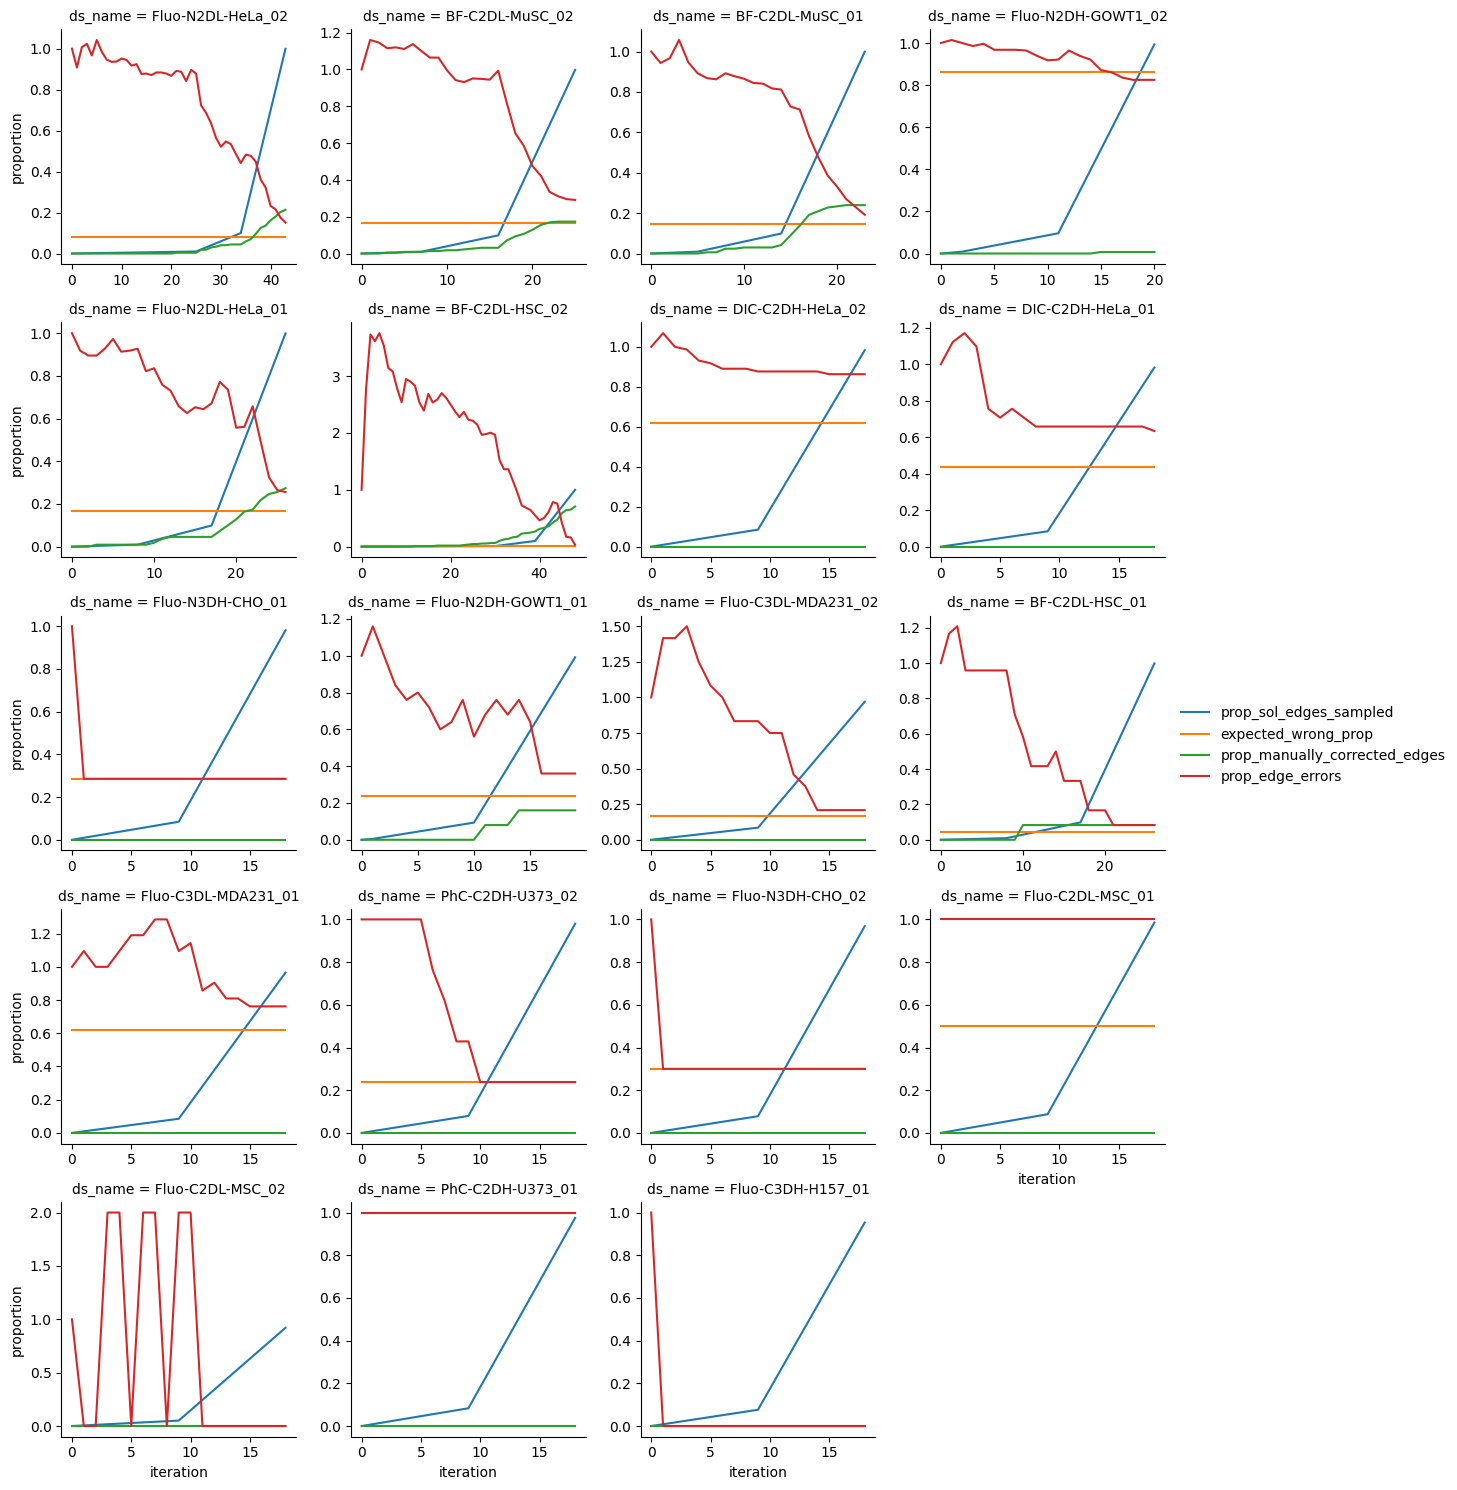

In [79]:
import seaborn as sns

grid = sns.FacetGrid(iter_melted, col='ds_name', col_order=plot_ds_name_order, col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.lineplot, x='iteration', y='proportion', hue='category')
grid.add_legend()

In [87]:
remaining_errors_cols = [
    'prop_sol_edges_sampled',
    'expected_wrong_prop',
    # 'prop_manually_corrected_edges',
    'prop_fp_edges', 
    'prop_fn_edges',
    'prop_ws_edges',
    'prop_edge_errors'
]
cols_to_keep = ['ds_name', 'n_sol_edges_sampled']
iter_up_close = iter_df[iter_df.n_sol_edges_sampled <= 200].melt(id_vars=cols_to_keep, value_vars=remaining_errors_cols, var_name='category', value_name='proportion')

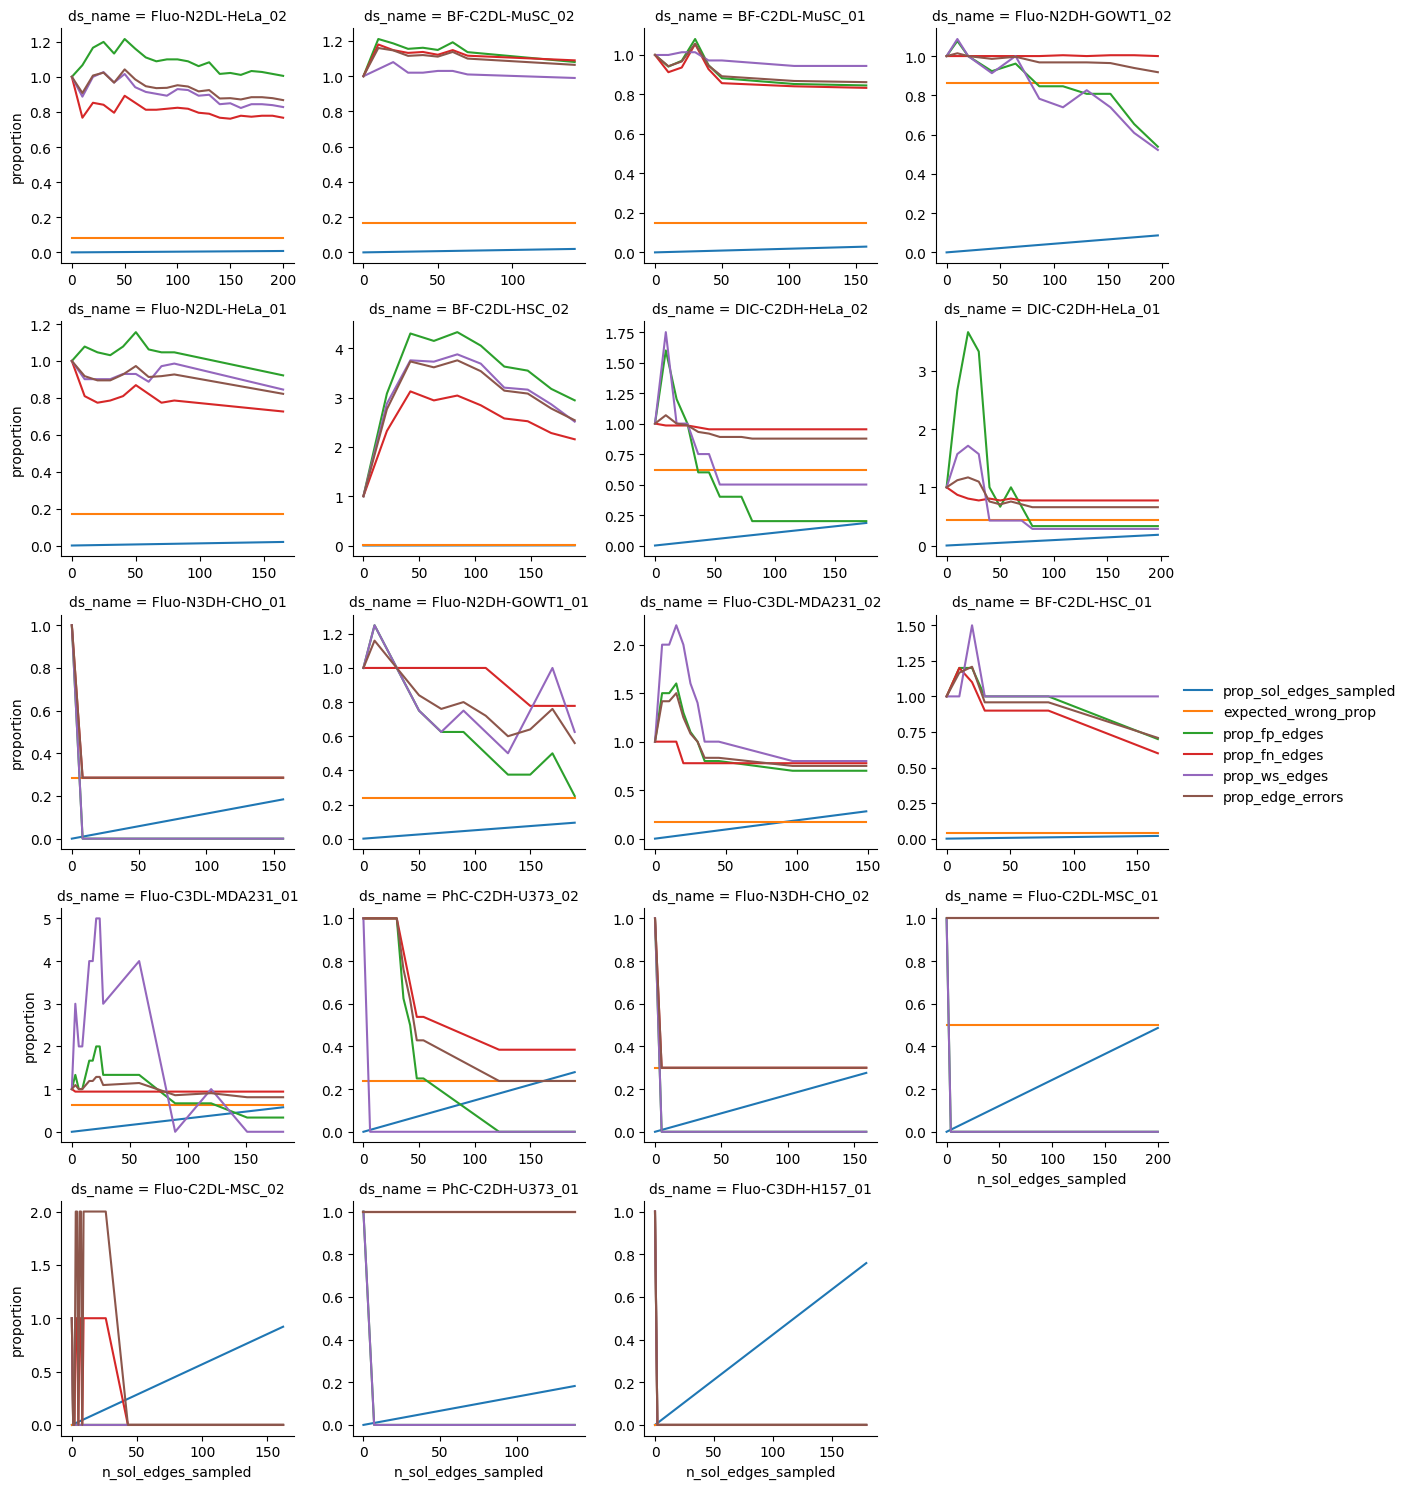

In [90]:
import seaborn as sns

grid = sns.FacetGrid(iter_up_close, col='ds_name', col_order=plot_ds_name_order, col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.lineplot, x='n_sol_edges_sampled', y='proportion', hue='category')
grid.add_legend()

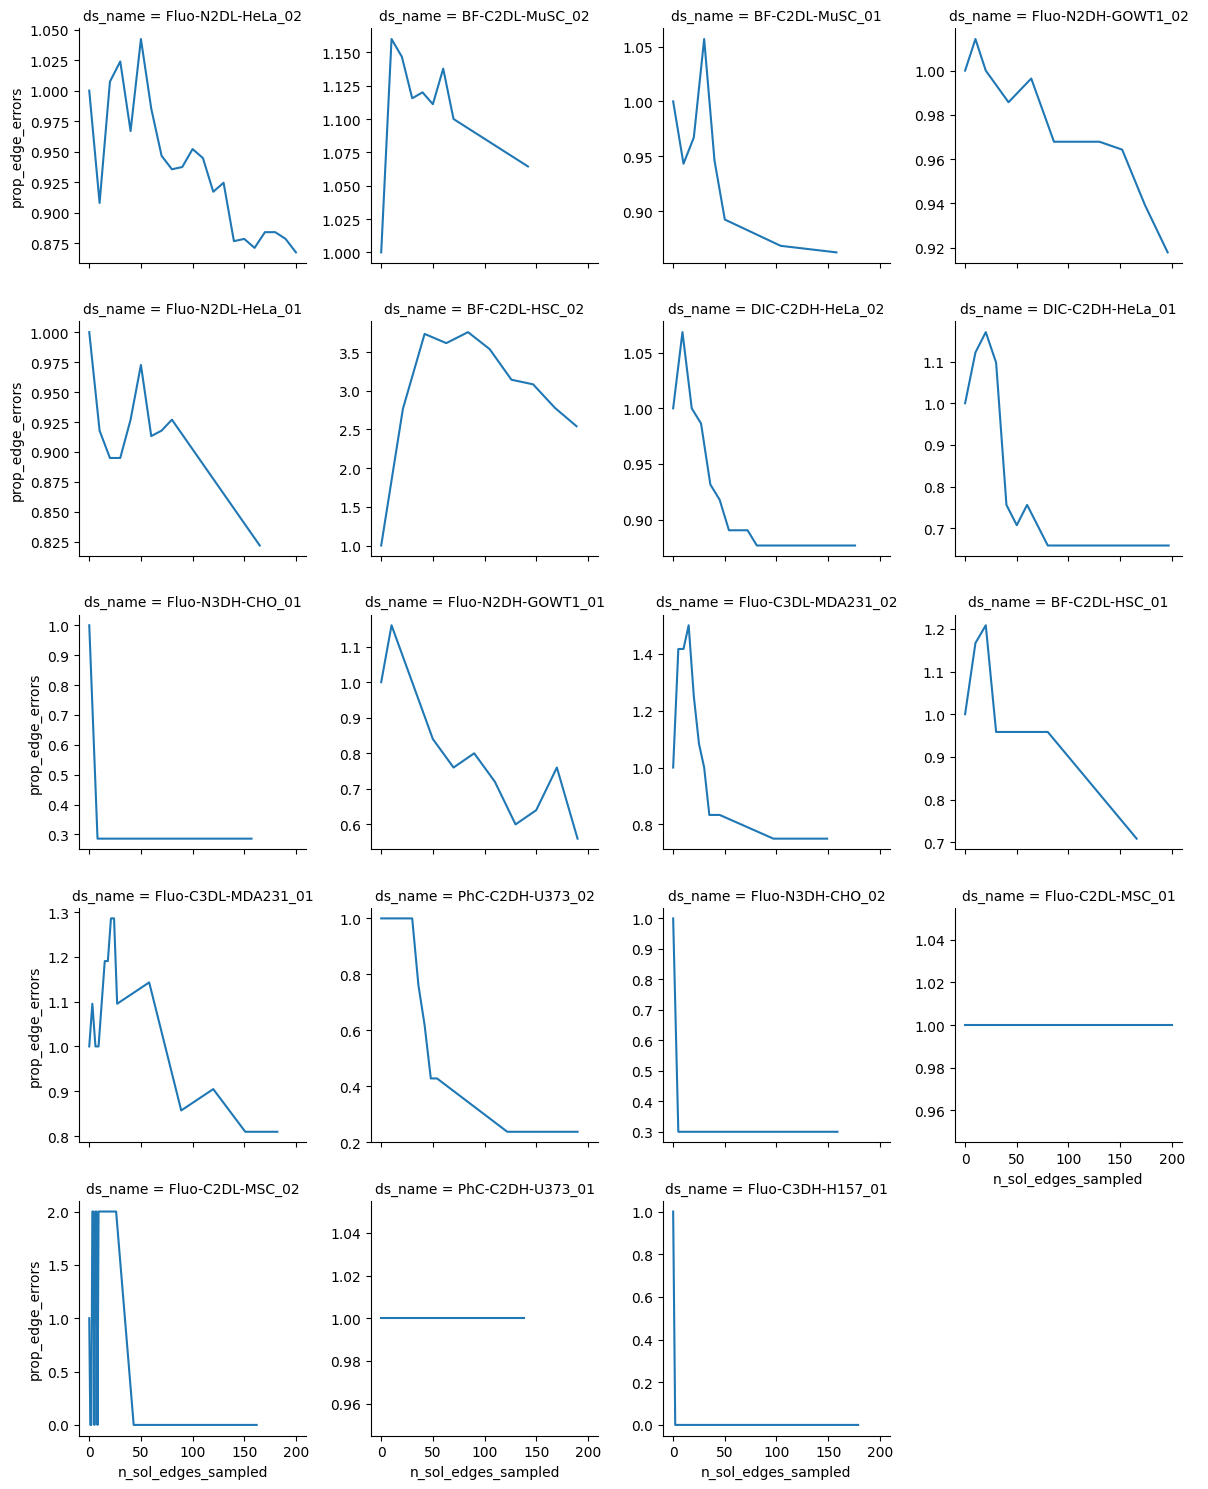

In [52]:
import seaborn as sns

starting_edge_errors = iter_df[iter_df['iteration'] == 0][['ds_name', 'total_edge_errors']]
starting_edge_errors.sort_values(by='total_edge_errors', ascending=False, inplace=True)
grid = sns.FacetGrid(iter_df[iter_df.n_sol_edges_sampled <= 200], col='ds_name', col_order=starting_edge_errors.ds_name, col_wrap=4, sharex=True, sharey=False, legend_out=True)
grid.map_dataframe(sns.lineplot, x='n_sol_edges_sampled', y='prop_edge_errors')
grid.add_legend()

In [38]:
starting_edge_errors

,ds_name,total_edge_errors
144,Fluo-N2DL-HeLa_02,543
345,BF-C2DL-MuSC_02,450
321,BF-C2DL-MuSC_01,334
58,Fluo-N2DH-GOWT1_02,280
117,Fluo-N2DL-HeLa_01,219
264,DIC-C2DH-HeLa_02,73
245,DIC-C2DH-HeLa_01,41
283,Fluo-N3DH-CHO_01,35
38,Fluo-N2DH-GOWT1_01,25
19,Fluo-C3DL-MDA231_02,24


In [48]:
iter_df[iter_df['ds_name'] == 'Fluo-N2DH-GOWT1_02']

,ds_name,iteration,total_sol_edges,n_sol_edges_sampled,prop_sol_edges_sampled,n_all_edges_sampled,prop_all_edges_sampled,n_manually_corrected_edges,prop_manually_corrected_edges,n_fp_edges,prop_fp_edges,n_fn_edges,prop_fn_edges,n_ws_edges,prop_ws_edges,total_edge_errors,prop_edge_errors,AOGM
58,Fluo-N2DH-GOWT1_02,0,2267,0,0.000000,0,0.000000,0,0.000000,26,1.000000,231,1.000000,23,1.000000,280,1.000000,2695.5
59,Fluo-N2DH-GOWT1_02,1,2267,10,0.004411,73,0.002478,0,0.000000,28,1.076923,231,1.000000,25,1.086957,284,1.014286,2699.5
60,Fluo-N2DH-GOWT1_02,2,2267,20,0.008822,146,0.004956,0,0.000000,26,1.000000,231,1.000000,23,1.000000,280,1.000000,2695.5
61,Fluo-N2DH-GOWT1_02,3,2267,42,0.018527,276,0.009369,0,0.000000,24,0.923077,231,1.000000,21,0.913043,276,0.985714,2691.5
62,Fluo-N2DH-GOWT1_02,4,2267,64,0.028231,388,0.013171,0,0.000000,25,0.961538,231,1.000000,23,1.000000,279,0.996429,2694.5
63,Fluo-N2DH-GOWT1_02,5,2267,86,0.037936,482,0.016362,0,0.000000,22,0.846154,231,1.000000,18,0.782609,271,0.967857,2686.5
64,Fluo-N2DH-GOWT1_02,6,2267,108,0.047640,566,0.019214,0,0.000000,22,0.846154,232,1.004329,17,0.739130,271,0.967857,2687.0
65,Fluo-N2DH-GOWT1_02,7,2267,130,0.057345,606,0.020572,0,0.000000,21,0.807692,231,1.000000,19,0.826087,271,0.967857,2686.5
66,Fluo-N2DH-GOWT1_02,8,2267,152,0.067049,655,0.022235,0,0.000000,21,0.807692,232,1.004329,17,0.739130,270,0.964286,2686.0
67,Fluo-N2DH-GOWT1_02,9,2267,174,0.076753,722,0.024509,0,0.000000,17,0.653846,232,1.004329,14,0.608696,263,0.939286,2679.0


In [95]:
# gathering info about each iteration for each dataset
# all cumulative
import json
import networkx as nx
import numpy as np
from experiment_schema import OUT_FILE


ds_info_lim = ds_info[ds_info.ds_name == 'BF-C2DL-HSC_02']
for i, row in ds_info_lim.iterrows():
    ds_name = row['ds_name']
    ds_out_root = os.path.join(iterative_root, ds_name)
    ds_init_root = os.path.join(initial_root, ds_name)
    if not os.path.exists(ds_out_root) or ds_name in ['Fluo-C3DH-H157_02', 'Fluo-C3DH-A549_01', 'Fluo-C3DH-A549_02', 'PhC-C2DL-PSC_01']:
        print("Solution not present ", ds_name)
        continue

    with open(os.path.join(ds_out_root, 'sampling_strategy.txt'), 'r') as f:
        sampling_strat = [int(line) for line in f]
    solution_graph = nx.read_graphml(os.path.join(ds_init_root, OUT_FILE.MATCHED_SOL.value), node_type=int)
    sol_cum_sampled = np.cumsum(sampling_strat)


    with open(os.path.join(ds_init_root, OUT_FILE.METRICS.value), 'r') as f:
        metrics = json.load(f)

    all_edges = pd.read_csv(os.path.join(ds_init_root, OUT_FILE.ALL_EDGES.value))
    
    total_init = (init_n_fp_edges + init_n_fn_edges + init_n_ws_edges)
    expected_wrong_edges = metrics['fn_nodes'] + row['total_skips']
    expected_wrong_prop = expected_wrong_edges / total_init if total_init != 0 else 0
    print("#" * 60)
    for i, it in enumerate(range(1, len(sampling_strat))):
        print("Looking at ", ds_name, 'it', it)

        all_edges_after_it = pd.read_csv(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.ALL_EDGES.value))
        print(all_edges_after_it['mig_predict_proba'].describe())
        print(f'Prob mig == 1', len(all_edges_after_it[all_edges_after_it['mig_predict_proba'] == 1]) / len(all_edges_after_it))
        with open(os.path.join(ds_out_root, f'{ds_name}_it{it}', OUT_FILE.METRICS.value), 'r') as f:
            metrics_after_it = json.load(f)
        print("#" * 60)

############################################################
Looking at  BF-C2DL-HSC_02 it 1
count    823850.000000
mean         -0.154642
std           0.532986
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: mig_predict_proba, dtype: float64
Prob mig == 1 0.025724343023608667
############################################################
Looking at  BF-C2DL-HSC_02 it 2
count    823850.000000
mean         -0.154625
std           0.535822
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: mig_predict_proba, dtype: float64
Prob mig == 1 0.054834011045700064
############################################################
Looking at  BF-C2DL-HSC_02 it 3
count    823850.000000
mean         -0.149726
std           0.538841
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: mig_predict_p

KeyboardInterrupt: 